# Data Wrangling Project

In [1]:
# Import the necceseary libraries to get started

import pandas as pd
import numpy as np
import requests
import tweepy
import json
import time
import re
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None

## 1. Gathering Data

The following cells gathers all the data required for this project. These are the WeRateDogs Twitter archive, the tweet image predictions and each tweet's retweet count and favourite count.

### 1.1. Gathering WeRateDogs Twitter Archive data

In [2]:
# Gather the WeRateDogs Twitter Archive and check.
# This file was manually downloaded and uploaded.

twitter_archive_df = pd.read_csv('twitter-archive-enhanced.csv')
twitter_archive_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


### 1.2. Gathering The tweet image predictions

In [3]:
# Download the tweet image predictions from Udacity's server 
r = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')

# save the data locally
with open("image_predictions.tsv", "w") as file:
    file.write(r.text)

# load the data into a dataframe
image_predictions_df = pd.read_csv('image_predictions.tsv', delimiter='\t')

# check the dataframe
image_predictions_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True




Each tweet's retweet count and favorite ("like") count at minimum, and any additional data you find interesting. Using the tweet IDs in the WeRateDogs Twitter archive, query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file called tweet_json.txt file. Each tweet's JSON data should be written to its own line. Then read this .txt file line by line into a pandas DataFrame with (at minimum) tweet ID, retweet count, and favorite count. Note: do not include your Twitter API keys, secrets, and tokens in your project submission.

### 1.3. Gathering each tweets's retween and favorite count

In [4]:
# Set up Tweepy object to connect to the Twitter API
consumer_key = '<consumer_key>'
consumer_secret = '<consumer_secret>'
access_token = '<access_token>'
access_secret = '<access_secret>'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

In [5]:
# Loop through the data and write each tweet as a json object on a new line to a file

start = time.time()

with open('tweet_json.txt', 'w') as file:
    tweet_no = 1
    total_tweet = twitter_archive_df.shape[0]
    tweet_error_list = []
    tweet_success_list = []
    for tweet_id in twitter_archive_df['tweet_id']:
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            json.dump(tweet._json, file)
            file.write("\n")
        except:
            print("ERROR on tweet number: " + str(tweet_no) + "/" + str(total_tweet))
            tweet_error_list.append(tweet_id)
        else:
            print("success on tweet number: " + str(tweet_no) + "/" + str(total_tweet))
            tweet_success_list.append(tweet_id)
        tweet_no+=1
            
end = time.time()
            
if len(tweet_error_list) > 0:
    print("\nThe following " + str(len(tweet_error_list)) + " tweets had errors: " +  str(tweet_error_list))
else:
    print("\nThere were no errors.")
print("\n"+ str(len(tweet_success_list)) + " tweets were written to file.")
print("\nOPERATION TOOK " + str(end - start) + " SECONDS TO COMPLETE.")

success on tweet number: 1/2356
success on tweet number: 2/2356
success on tweet number: 3/2356
success on tweet number: 4/2356
success on tweet number: 5/2356
success on tweet number: 6/2356
success on tweet number: 7/2356
success on tweet number: 8/2356
success on tweet number: 9/2356
success on tweet number: 10/2356
success on tweet number: 11/2356
success on tweet number: 12/2356
success on tweet number: 13/2356
success on tweet number: 14/2356
success on tweet number: 15/2356
success on tweet number: 16/2356
success on tweet number: 17/2356
success on tweet number: 18/2356
success on tweet number: 19/2356
ERROR on tweet number: 20/2356
success on tweet number: 21/2356
success on tweet number: 22/2356
success on tweet number: 23/2356
success on tweet number: 24/2356
success on tweet number: 25/2356
success on tweet number: 26/2356
success on tweet number: 27/2356
success on tweet number: 28/2356
success on tweet number: 29/2356
success on tweet number: 30/2356
success on tweet numb

success on tweet number: 247/2356
ERROR on tweet number: 248/2356
success on tweet number: 249/2356
success on tweet number: 250/2356
success on tweet number: 251/2356
success on tweet number: 252/2356
success on tweet number: 253/2356
ERROR on tweet number: 254/2356
success on tweet number: 255/2356
success on tweet number: 256/2356
success on tweet number: 257/2356
success on tweet number: 258/2356
success on tweet number: 259/2356
success on tweet number: 260/2356
ERROR on tweet number: 261/2356
success on tweet number: 262/2356
success on tweet number: 263/2356
success on tweet number: 264/2356
success on tweet number: 265/2356
success on tweet number: 266/2356
success on tweet number: 267/2356
success on tweet number: 268/2356
success on tweet number: 269/2356
success on tweet number: 270/2356
success on tweet number: 271/2356
success on tweet number: 272/2356
success on tweet number: 273/2356
success on tweet number: 274/2356
success on tweet number: 275/2356
success on tweet num

success on tweet number: 490/2356
success on tweet number: 491/2356
success on tweet number: 492/2356
success on tweet number: 493/2356
success on tweet number: 494/2356
success on tweet number: 495/2356
success on tweet number: 496/2356
success on tweet number: 497/2356
success on tweet number: 498/2356
success on tweet number: 499/2356
success on tweet number: 500/2356
success on tweet number: 501/2356
success on tweet number: 502/2356
ERROR on tweet number: 503/2356
success on tweet number: 504/2356
success on tweet number: 505/2356
success on tweet number: 506/2356
ERROR on tweet number: 507/2356
success on tweet number: 508/2356
success on tweet number: 509/2356
success on tweet number: 510/2356
success on tweet number: 511/2356
success on tweet number: 512/2356
success on tweet number: 513/2356
success on tweet number: 514/2356
success on tweet number: 515/2356
success on tweet number: 516/2356
success on tweet number: 517/2356
success on tweet number: 518/2356
success on tweet n

success on tweet number: 732/2356
success on tweet number: 733/2356
success on tweet number: 734/2356
success on tweet number: 735/2356
success on tweet number: 736/2356
success on tweet number: 737/2356
success on tweet number: 738/2356
success on tweet number: 739/2356
success on tweet number: 740/2356
success on tweet number: 741/2356
success on tweet number: 742/2356
success on tweet number: 743/2356
success on tweet number: 744/2356
success on tweet number: 745/2356
success on tweet number: 746/2356
success on tweet number: 747/2356
success on tweet number: 748/2356
success on tweet number: 749/2356
success on tweet number: 750/2356
ERROR on tweet number: 751/2356
success on tweet number: 752/2356
success on tweet number: 753/2356
success on tweet number: 754/2356
success on tweet number: 755/2356
success on tweet number: 756/2356
success on tweet number: 757/2356
success on tweet number: 758/2356
success on tweet number: 759/2356
success on tweet number: 760/2356
success on tweet

success on tweet number: 975/2356
success on tweet number: 976/2356
success on tweet number: 977/2356
success on tweet number: 978/2356
success on tweet number: 979/2356
success on tweet number: 980/2356
success on tweet number: 981/2356
success on tweet number: 982/2356
success on tweet number: 983/2356
success on tweet number: 984/2356
success on tweet number: 985/2356
success on tweet number: 986/2356
success on tweet number: 987/2356
success on tweet number: 988/2356
success on tweet number: 989/2356
success on tweet number: 990/2356
success on tweet number: 991/2356
success on tweet number: 992/2356
success on tweet number: 993/2356
success on tweet number: 994/2356
success on tweet number: 995/2356
success on tweet number: 996/2356
success on tweet number: 997/2356
success on tweet number: 998/2356
success on tweet number: 999/2356
success on tweet number: 1000/2356
success on tweet number: 1001/2356
success on tweet number: 1002/2356
success on tweet number: 1003/2356
success on

success on tweet number: 1211/2356
success on tweet number: 1212/2356
success on tweet number: 1213/2356
success on tweet number: 1214/2356
success on tweet number: 1215/2356
success on tweet number: 1216/2356
success on tweet number: 1217/2356
success on tweet number: 1218/2356
success on tweet number: 1219/2356
success on tweet number: 1220/2356
success on tweet number: 1221/2356
success on tweet number: 1222/2356
success on tweet number: 1223/2356
success on tweet number: 1224/2356
success on tweet number: 1225/2356
success on tweet number: 1226/2356
success on tweet number: 1227/2356
success on tweet number: 1228/2356
success on tweet number: 1229/2356
success on tweet number: 1230/2356
success on tweet number: 1231/2356
success on tweet number: 1232/2356
success on tweet number: 1233/2356
success on tweet number: 1234/2356
success on tweet number: 1235/2356
success on tweet number: 1236/2356
success on tweet number: 1237/2356
success on tweet number: 1238/2356
success on tweet num

success on tweet number: 1446/2356
success on tweet number: 1447/2356
success on tweet number: 1448/2356
success on tweet number: 1449/2356
success on tweet number: 1450/2356
success on tweet number: 1451/2356
success on tweet number: 1452/2356
success on tweet number: 1453/2356
success on tweet number: 1454/2356
success on tweet number: 1455/2356
success on tweet number: 1456/2356
success on tweet number: 1457/2356
success on tweet number: 1458/2356
success on tweet number: 1459/2356
success on tweet number: 1460/2356
success on tweet number: 1461/2356
success on tweet number: 1462/2356
success on tweet number: 1463/2356
success on tweet number: 1464/2356
success on tweet number: 1465/2356
success on tweet number: 1466/2356
success on tweet number: 1467/2356
success on tweet number: 1468/2356
success on tweet number: 1469/2356
success on tweet number: 1470/2356
success on tweet number: 1471/2356
success on tweet number: 1472/2356
success on tweet number: 1473/2356
success on tweet num

success on tweet number: 1681/2356
success on tweet number: 1682/2356
success on tweet number: 1683/2356
success on tweet number: 1684/2356
success on tweet number: 1685/2356
success on tweet number: 1686/2356
success on tweet number: 1687/2356
success on tweet number: 1688/2356
success on tweet number: 1689/2356
success on tweet number: 1690/2356
success on tweet number: 1691/2356
success on tweet number: 1692/2356
success on tweet number: 1693/2356
success on tweet number: 1694/2356
success on tweet number: 1695/2356
success on tweet number: 1696/2356
success on tweet number: 1697/2356
success on tweet number: 1698/2356
success on tweet number: 1699/2356
success on tweet number: 1700/2356
success on tweet number: 1701/2356
success on tweet number: 1702/2356
success on tweet number: 1703/2356
success on tweet number: 1704/2356
success on tweet number: 1705/2356
success on tweet number: 1706/2356
success on tweet number: 1707/2356
success on tweet number: 1708/2356
success on tweet num

success on tweet number: 1917/2356
success on tweet number: 1918/2356
success on tweet number: 1919/2356
success on tweet number: 1920/2356
success on tweet number: 1921/2356
success on tweet number: 1922/2356
success on tweet number: 1923/2356
success on tweet number: 1924/2356
success on tweet number: 1925/2356
success on tweet number: 1926/2356
success on tweet number: 1927/2356
success on tweet number: 1928/2356
success on tweet number: 1929/2356
success on tweet number: 1930/2356
success on tweet number: 1931/2356
success on tweet number: 1932/2356
success on tweet number: 1933/2356
success on tweet number: 1934/2356
success on tweet number: 1935/2356
success on tweet number: 1936/2356
success on tweet number: 1937/2356
success on tweet number: 1938/2356
success on tweet number: 1939/2356
success on tweet number: 1940/2356
success on tweet number: 1941/2356
success on tweet number: 1942/2356
success on tweet number: 1943/2356
success on tweet number: 1944/2356
success on tweet num

success on tweet number: 2152/2356
success on tweet number: 2153/2356
success on tweet number: 2154/2356
success on tweet number: 2155/2356
success on tweet number: 2156/2356
success on tweet number: 2157/2356
success on tweet number: 2158/2356
success on tweet number: 2159/2356
success on tweet number: 2160/2356
success on tweet number: 2161/2356
success on tweet number: 2162/2356
success on tweet number: 2163/2356
success on tweet number: 2164/2356
success on tweet number: 2165/2356
success on tweet number: 2166/2356
success on tweet number: 2167/2356
success on tweet number: 2168/2356
success on tweet number: 2169/2356
success on tweet number: 2170/2356
success on tweet number: 2171/2356
success on tweet number: 2172/2356
success on tweet number: 2173/2356
success on tweet number: 2174/2356
success on tweet number: 2175/2356
success on tweet number: 2176/2356
success on tweet number: 2177/2356
success on tweet number: 2178/2356
success on tweet number: 2179/2356
success on tweet num

In [6]:
# Read tweet_json.txt and create a dataframe with tweet ID, retweet count, and favorite count

tweet_stats_df = pd.DataFrame(columns = ['tweet_id', 'retweet_count', 'favorite_count'])
with open('tweet_json.txt', 'r') as file:
    for line in file:
        tweet = json.loads(line)
        tweet_id = tweet['id']
        retweet_count = tweet['retweet_count']
        favorite_count = tweet['favorite_count']
        tweet_stats_df = tweet_stats_df.append({'tweet_id':tweet_id, 'retweet_count':retweet_count, 
                                                'favorite_count':favorite_count}, ignore_index=True)
        
tweet_stats_df['tweet_id'] = tweet_stats_df['tweet_id'].astype(np.int64)
tweet_stats_df['retweet_count'] = tweet_stats_df['retweet_count'].astype(np.int64)
tweet_stats_df['favorite_count'] = tweet_stats_df['favorite_count'].astype(np.int64)

print(tweet_stats_df.info())
tweet_stats_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2332 entries, 0 to 2331
Data columns (total 3 columns):
tweet_id          2332 non-null int64
retweet_count     2332 non-null int64
favorite_count    2332 non-null int64
dtypes: int64(3)
memory usage: 54.7 KB
None


,tweet_id,retweet_count,favorite_count
0,892420643555336193,7929,37113
1,892177421306343426,5889,31933
2,891815181378084864,3892,24037
3,891689557279858688,8088,40430
4,891327558926688256,8768,38657


## 2. Assessing Data

The following cells will visually and progamatically assess the data we gathered. We now currently have 3 dataframes: twitter_archive_df, image_predictions_df and tweet_stats_df. 

#### twitter_archive_df Assessment

First, let's visually explore the dataframe.

In [7]:
twitter_archive_df.sample(20)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
854,765222098633691136,NaN,NaN,2016-08-15 16:22:20 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Gromit. He's pupset because there's no...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/765222098...,10,10,Gromit,None,None,None,None
1009,747512671126323200,NaN,NaN,2016-06-27 19:31:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Guys pls stop sending actual sharks. It's too ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/747512671...,10,10,None,None,None,None,None
390,826240494070030336,NaN,NaN,2017-01-31 01:27:39 +0000,"<a href=""http://twitter.com/download/iphone"" r...",We only rate dogs. Please don't send in any mo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/826240494...,11,10,None,None,None,None,None
584,800141422401830912,NaN,NaN,2016-11-20 00:59:15 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Peaches. She's the ultimate selfie sid...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/800141422...,13,10,Peaches,None,None,None,None
592,798933969379225600,NaN,NaN,2016-11-16 17:01:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Iroh. He's in a predicament. 12/10 som...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/798933969...,12,10,Iroh,None,None,None,None
642,793210959003287553,NaN,NaN,2016-10-31 22:00:04 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Maude. She's the h*ckin happiest wasp ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/793210959...,10,10,Maude,None,None,None,None
1096,736365877722001409,NaN,NaN,2016-05-28 01:18:00 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Rory. He's extremely impatient. 11/10 ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/736365877...,11,10,Rory,None,None,pupper,None
765,777885040357281792,NaN,NaN,2016-09-19 15:00:20 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Wesley. He's clearly trespassing. Seem...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/777885040...,3,10,Wesley,None,None,None,None
950,752173152931807232,NaN,NaN,2016-07-10 16:10:29 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Brody. He's a lifeguard. Always prepar...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/752173152...,12,10,Brody,None,None,None,None
2260,667550882905632768,NaN,NaN,2015-11-20 03:51:47 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",RT @dogratingrating: Unoriginal idea. Blatant ...,6.675484e+17,4.296832e+09,2015-11-20 03:41:59 +0000,https://twitter.com/dogratingrating/status/667...,5,10,None,None,None,None,None


Visually, there are a few things wrong with the quality of the data here:

- There are some retweets and replies.
- The 'expanded_urls', 'source' and 'name' column names are unclear.

We can also see a tidiness issue:

- On twitter_archive_df, the 4 different columns doggo, floofer, pupper and puppo, are all relative to the same variable that identifies the stage of dog.

Now, let's assess this dataframe programatically.

In [8]:
# Have look at the key information of the dataframe

twitter_archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [9]:
twitter_archive_df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [10]:
twitter_archive_df['source'].value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [11]:
twitter_archive_df['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [12]:
twitter_archive_df['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [13]:
(twitter_archive_df['rating_numerator']/twitter_archive_df['rating_denominator']).value_counts()

1.200000      562
1.100000      469
1.000000      463
1.300000      351
0.900000      157
0.800000      102
0.700000       54
1.400000       54
0.500000       38
0.600000       32
0.300000       19
0.400000       15
0.200000       11
0.100000        8
42.000000       2
1.500000        2
0.000000        2
7.500000        2
0.818182        2
1.250000        1
66.600000       1
inf             1
1.700000        1
3.428571        1
0.636364        1
2.700000        1
0.733333        1
2.600000        1
18.200000       1
177.600000      1
dtype: int64

In [14]:
twitter_archive_df['name'].value_counts()

None         745
a             55
Charlie       12
Oliver        11
Cooper        11
Lucy          11
Tucker        10
Lola          10
Penny         10
Bo             9
Winston        9
the            8
Sadie          8
Toby           7
an             7
Bailey         7
Daisy          7
Buddy          7
Leo            6
Scout          6
Rusty          6
Oscar          6
Dave           6
Milo           6
Jack           6
Bella          6
Jax            6
Koda           6
Stanley        6
George         5
            ... 
Tommy          1
Vince          1
Edmund         1
Vinscent       1
Arya           1
Superpup       1
Alfy           1
Kane           1
Charl          1
Ace            1
Jimbo          1
Rey            1
Einstein       1
Duchess        1
Rover          1
Lillie         1
Dex            1
Shnuggles      1
Harrison       1
Stella         1
Barry          1
Combo          1
Ralpher        1
Orion          1
Ruffles        1
Rueben         1
Jebberson      1
Stuart        

In [15]:
twitter_archive_df['doggo'].value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [16]:
twitter_archive_df['floofer'].value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [17]:
twitter_archive_df['pupper'].value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [18]:
twitter_archive_df['puppo'].value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

In [19]:
# Check to see if there are tweets with multiple dog stage labels

dog_stages = twitter_archive_df[['doggo', 'floofer', 'pupper', 'puppo']]
dog_stages['doggo'] = dog_stages['doggo'].map({'None':False, 'doggo':True})
dog_stages['floofer'] = dog_stages['floofer'].map({'None':False, 'floofer':True})
dog_stages['pupper'] = dog_stages['pupper'].map({'None':False, 'pupper':True})
dog_stages['puppo'] = dog_stages['puppo'].map({'None':False, 'puppo':True})

len(twitter_archive_df[dog_stages.sum(axis=1) > 1])

14

For the Dog Stages columns, it's not clear if a dog/tweet can have multiple labels at the same time but there are some records in the data showing that this happens sometimes (14 times). For the purpose of this project, we will assume that these are mistakes and remove them as we tidy the columns

In [20]:
# Check for duplicates
twitter_archive_df.duplicated('tweet_id').sum()

0

Looking at the key information of the dataframe. The following data quality issues can be identified in addition to the ones from the visual inspection:

- The 'timstamp' data is not using the correct data type.
- The 'source' data contains only 4 unique values. This can be a category datatype rather than object.
- The 'source' information contains unnecesary HTML.
- The 'rating_numerator'/'rating_denominator' value has some odd results like infinity.
- There are some dog names that likely are to be mistakes. Ie. 'a', 'an' and 'the'.


#### image_predictions_df Assessment

Now, it's time to assess the second dataframe, image_predictions_df. We will look at it visually first.

In [21]:
image_predictions_df.sample(20)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
922,702217446468493312,https://pbs.twimg.com/media/Cb7HCMkWEAAV9zY.jpg,1,golden_retriever,0.242419,True,chow,0.226800,True,cocker_spaniel,0.194086,True
1285,750719632563142656,https://pbs.twimg.com/media/CmsXg9AWgAAs6Ui.jpg,1,Pembroke,0.972587,True,Cardigan,0.014772,True,basenji,0.005798,True
1197,740676976021798912,https://pbs.twimg.com/media/Ckdpx5KWsAANF6b.jpg,1,wombat,0.462952,False,Norwegian_elkhound,0.275225,True,Siamese_cat,0.043559,False
1395,767754930266464257,https://pbs.twimg.com/media/CqedCQWWgAIab9L.jpg,1,vizsla,0.307794,True,fountain,0.142185,False,Chesapeake_Bay_retriever,0.113903,True
177,669214165781868544,https://pbs.twimg.com/media/CUmGu7-UcAA0r3O.jpg,1,minivan,0.435396,False,police_van,0.310143,False,minibus,0.068201,False
280,671115716440031232,https://pbs.twimg.com/media/CVBILUgVAAA1ZUr.jpg,1,malinois,0.406341,True,kelpie,0.143366,True,dingo,0.129802,False
2043,885984800019947520,https://pbs.twimg.com/media/DEumeWWV0AA-Z61.jpg,1,Blenheim_spaniel,0.972494,True,Shih-Tzu,0.006630,True,Bernese_mountain_dog,0.006239,True
1775,828372645993398273,https://pbs.twimg.com/media/C374hb0WQAAIbQ-.jpg,1,malamute,0.663047,True,Eskimo_dog,0.207779,True,Tibetan_mastiff,0.040949,True
1029,711008018775851008,https://pbs.twimg.com/media/Cd4CBQFW8AAY3ND.jpg,1,French_bulldog,0.731405,True,Boston_bull,0.150672,True,pug,0.021811,True
1706,817536400337801217,https://pbs.twimg.com/media/C1h4_MEXUAARxQF.jpg,2,pug,0.971358,True,French_bulldog,0.028518,True,Boston_bull,0.000086,True


Visually, we can see the following data quality issue:

- The column names are unclear

There is also a data tidiness issues are per below:

- This dataframe is part of the twitter observational unit.

Now, let's look at this data programatically.

In [22]:
image_predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [23]:
image_predictions_df.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [24]:
image_predictions_df.duplicated('tweet_id').sum()

0

In [25]:
image_predictions_df['img_num'].value_counts()

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

From the progamatic assessment, the data quality issues that we can see include:

- the 'img_num' column uses an inapropriate data type. Eventhough the data itself is an integer, it can only be 1, 2, 3 or 4. For this reason, the category data type may be more appropriate.

#### tweet_stats_df Assessment

The last dataframe we will assess is the tweet_stats_df. Let's start with visually looking at this data.

In [26]:
tweet_stats_df.sample(20)

,tweet_id,retweet_count,favorite_count
969,748692773788876800,1363,4353
139,863553081350529029,4045,14943
667,788070120937619456,3605,0
1134,724405726123311104,1678,5385
2185,668623201287675904,750,1406
560,800513324630806528,3158,13733
1532,688894073864884227,710,2288
1628,683498322573824003,982,3234
1581,685906723014619143,2968,7677
1668,681320187870711809,770,2694


Visually, there is an issue with tidiness:

- This dataframe is part of the twitter_archive_df observational unit.

In [27]:
tweet_stats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2332 entries, 0 to 2331
Data columns (total 3 columns):
tweet_id          2332 non-null int64
retweet_count     2332 non-null int64
favorite_count    2332 non-null int64
dtypes: int64(3)
memory usage: 54.7 KB


In [28]:
tweet_stats_df.describe()

,tweet_id,retweet_count,favorite_count
count,2.332000e+03,2332.000000,2332.000000
mean,7.418974e+17,2790.566038,7738.518010
std,6.820477e+16,4724.569180,12017.191734
min,6.660209e+17,1.000000,0.000000
25%,6.782728e+17,559.500000,1339.000000
50%,7.183508e+17,1302.500000,3370.000000
75%,7.986494e+17,3247.250000,9491.250000
max,8.924206e+17,80188.000000,160353.000000


In [29]:
tweet_stats_df.duplicated('tweet_id').sum()

0

Based on the programatic assessment, the data looks clean.

#### Summary of Assessment

**Data quality issues (9):**

- On *twitter_archive_df*, there are some retweets and replies.
- On *twitter_archive_df*, the expanded_urls', 'source' and 'name' column names are unclear.
- On *twitter_archive_df*, the 'timstamp' data is not using the correct data type.
- On *twitter_archive_df*, the 'source' data contains only 4 unique values. This can be a category datatype rather than object.
- On *twitter_archive_df*, the 'source' information contains unnecesary HTML.
- On *twitter_archive_df*, the 'rating_numerator'/'rating_denominator' value has some odd results like infinity.
- On *twitter_archive_df*, there are some dog names that likely are to be mistakes. Ie. 'a', 'an' and 'the'.
- On *image_predictions_df*, the column names are unclear.
- On *image_predictions_df*, the 'image_num' column has an inappropriate data type.

**Data tidiness issues (3):**

- image_predictions_df is part of the same observational unit as twitter_archive_df.
- tweet_stats_df is part of the same observational unit as twitter_archive_df.
- On twitter_archive_df, the 4 different columns doggo, floofer, pupper and puppo, are all relative to the same variable that identifies the stage of dog.


## 3. Cleaning Data

The following cells will clean the data identified in the assessment section. The cleaning process will be done in 3 steps: define, code and test.

First, let's create a copy of all the dataframes:

In [30]:
# Make copies of all the dataframes

tadf_clean = twitter_archive_df.copy()
ipdf_clean = image_predictions_df.copy()
tsdf_clean = tweet_stats_df.copy()

Now, we will define the cleaning steps for each issue from the issue list we made in the assessment summary section. The cleaning steps below will be followed in order. For each step, we will code and test it below.

**Data Completion Quality Steps:**
1. On twitter_archive_df, remove the retweets and replies and drop retweet and reply related columns (unnecessary data).

**Data Tidiness Steps:**
2. On twitter_archive_df, melt the 4 different columns doggo, floofer, pupper and puppo together into a single column named "dog stage".
3. tweet_stats_df is part of the same observational unit as twitter_archive_df and therefore should be merged. Disregard any teeets without a favoruite and retweet count as they may no longer be valid.
4. image_predictions_df is part of the same observational unit as twitter_archive_df and therefore should be merged. Select the most probable dog breed from image_predictions_df for the merging as all the predictions probabilities is not required for the analysis.

**Remaining Data Quality Steps:**
5. On twitter_archive_df, check and correct 'rating_numerator' and 'rating_denominator' for accuracy (accuracy issue).
6. On twitter_archive_df, remove names that likely are to be mistakes, including 'a', 'an' and 'the' (accuracy issue).
7. On twitter_archive_df, appropriatly rename the 'expanded_urls', 'source' and 'name' columns to be clear (consistency issue).
8. On twitter_archive_df, appropriatly rename the newly added columns from image_predictions_df (consistency issue).
9. On twitter_archive_df, change the 'timstamp' data to use the datetime datatype (validity issue).
10. On twitter_archive_df, remove the unnecesary HTML from the 'source' column (consistency issue).
11. On twitter_archive_df, change the 'source' data to use the category data type (validity issue).
12. On twitter_archive_df, change the 'selected_image_numer' data to use the category data type (validity issue).

**1. On twitter_archive_df, remove the retweets and replies and drop retweet and reply related columns.**

In [31]:
# Code

tadf_clean = tadf_clean[tadf_clean[['retweeted_status_id', 'in_reply_to_status_id']].isnull().all(axis=1)]


In [32]:
# Test

assert tadf_clean[['retweeted_status_id', 'in_reply_to_status_id']].isnull().all().all() == True


In [33]:
# Code

tadf_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 
     'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1, inplace=True)

In [34]:
# Test

assert 'in_reply_to_status_id' not in tadf_clean.columns.values
assert 'in_reply_to_user_id' not in tadf_clean.columns.values
assert 'retweeted_status_id' not in tadf_clean.columns.values
assert 'retweeted_status_user_id' not in tadf_clean.columns.values
assert 'retweeted_status_timestamp' not in tadf_clean.columns.values

**2. On twitter_archive_df, melt the 4 different columns doggo, floofer, pupper and puppo together into a single column named "dog stage".**

In [35]:
# Code

# Map object 'None' values to Null values to ease and speed up cleaning
tadf_clean['doggo'] = tadf_clean['doggo'].map({'None':None, 'doggo':'doggo'})
tadf_clean['floofer'] = tadf_clean['floofer'].map({'None':None, 'floofer':'floofer'})
tadf_clean['pupper'] = tadf_clean['pupper'].map({'None':None, 'pupper':'pupper'})
tadf_clean['puppo'] = tadf_clean['puppo'].map({'None':None, 'puppo':'puppo'})

# Remove tweets with more than one dog stage assigned
tadf_clean = tadf_clean[tadf_clean[['doggo', 'floofer', 'pupper', 'puppo']].notnull().sum(axis=1)<2]

# Split the dataframe to have only values with dog stages
tadf_dogs = (tadf_clean[tadf_clean[['doggo', 'floofer', 'pupper', 'puppo']].notnull().any(axis=1)]).copy()

# Melt the dog stages column to be one
melted = pd.melt(tadf_dogs, id_vars=['tweet_id'], 
            value_vars=['doggo', 'floofer', 'pupper', 'puppo'], 
            value_name="dog_stage").set_index('tweet_id').drop(columns={'variable'}).dropna()

# Join the melted data back to the original data
tadf_clean.set_index('tweet_id', inplace=True)
tadf_clean = tadf_clean.join(melted)
tadf_clean.reset_index(inplace=True)

# Drop the melted columns
tadf_clean = tadf_clean.drop(columns={'doggo', 'floofer', 'pupper', 'puppo'})

In [36]:
# Test

assert 'dog_stage' in tadf_clean.columns.values
assert 'doggo' not in tadf_clean.columns.values
assert 'floofer' not in tadf_clean.columns.values
assert 'pupper' not in tadf_clean.columns.values
assert 'puppo' not in tadf_clean.columns.values
assert tadf_clean.shape[0] == 2086
assert tadf_clean['dog_stage'].notnull().sum() == 325

#### **3. tweet_stats_df is part of the same observational unit as twitter_archive_df and therefore should be merged. Disregard any teeets without a favoruite and retweet count as they may no longer be valid.**

In [37]:
# Code

# Set the index of the 2 datframes appropriate for joining
tadf_clean.set_index('tweet_id', inplace=True);
tsdf_clean.set_index('tweet_id', inplace=True)

# Join the relevant data
tadf_clean = tadf_clean.join(tsdf_clean)

# Reset index to be as before
tadf_clean.reset_index(inplace=True)
tsdf_clean.reset_index(inplace=True)

# Drop all rows without retweet and favorite count
tadf_clean.dropna(subset = ['retweet_count', 'favorite_count'], inplace=True)

In [38]:
# Test

assert 'retweet_count' in tadf_clean.columns.values
assert 'favorite_count' in tadf_clean.columns.values
assert tadf_clean[['retweet_count', 'favorite_count']].isnull().all().all() == False

**4. image_predictions_df is part of the same observational unit as twitter_archive_df and therefore should be merged. Select the most probable dog breed from image_predictions_df for the merging as all the predictions probabilities is not required for the analysis.**

In [39]:
# Code

# By default, set the predicted dog value to be the most confident prediction
ipdf_clean['predicted_dog_breed'] = ipdf_clean['p1']

# If the most confident prediction is not a dog breed, use the next most confident prediction if its a dog breed
for i in ipdf_clean[ipdf_clean['p1_dog'] == False].index:
    if ipdf_clean.loc[i]['p2_dog'] == True:
        ipdf_clean.at[i, 'predicted_dog_breed'] = ipdf_clean.loc[i]['p2']
    elif ipdf_clean.loc[i]['p3_dog'] == True:
        ipdf_clean.at[i, 'predicted_dog_breed'] = ipdf_clean.loc[i]['p3']
    else:
        ipdf_clean.at[i, 'predicted_dog_breed'] = None

# Set the index of the 2 datframes appropriate for joining
ipdf_clean.set_index('tweet_id', inplace=True)
tadf_clean.set_index('tweet_id', inplace=True)

# Join the relevant data
tadf_clean = tadf_clean.join(ipdf_clean[['jpg_url', 'img_num', 'predicted_dog_breed']])

# Reset index to be as before
ipdf_clean.reset_index(inplace=True)
tadf_clean.reset_index(inplace=True)

# Remove any rows without images
tadf_clean = tadf_clean[tadf_clean['jpg_url'].notnull()]

In [40]:
# Test

assert 'jpg_url' in tadf_clean.columns.values
assert 'img_num' in tadf_clean.columns.values
assert tadf_clean[['jpg_url', 'img_num']].isnull().all().all() == False
assert 'predicted_dog_breed' in tadf_clean.columns.values

# Check a few values to make sure it's correct in all cases
tadf_clean.set_index('tweet_id', inplace=True)
assert tadf_clean.loc[666020888022790149]['predicted_dog_breed'] == "Welsh_springer_spaniel" # p1 selection
assert tadf_clean.loc[666051853826850816]['predicted_dog_breed'] == None # no selection
assert tadf_clean.loc[891689557279858688]['predicted_dog_breed'] == "Labrador_retriever" # p2 selection
assert tadf_clean.loc[882045870035918850]['predicted_dog_breed'] == "golden_retriever" # p3 selection
tadf_clean.reset_index(inplace=True)

**5. On twitter_archive_df, check and correct 'rating_numerator' and 'rating_denominator' for accuracy (accuracy issue).**

In [41]:
# Code

# Extract the rating from the text
rating = tadf_clean['text'].str.extract('((?:\d+\.)?\d+)\/(\d+)', expand=True)
rating.columns = ['rating_numerator', 'rating_denominator']

# Converted the extracted rating to an appropriate data type
rating['rating_numerator'] = pd.to_numeric(rating['rating_numerator'])
rating['rating_denominator'] = pd.to_numeric(rating['rating_denominator'])
rating['score'] = rating['rating_numerator'] / rating['rating_denominator']

# Adjust the ratings in the main dataset
tadf_clean['rating_numerator'] = rating['rating_numerator']
tadf_clean['rating_denominator'] = rating['rating_denominator']

# Remove ratings with 0 as denominator
tadf_clean = tadf_clean[tadf_clean['rating_denominator'] != 0]

In [42]:
# Test

assert 0 not in tadf_clean['rating_denominator'].unique()
assert tadf_clean['rating_denominator'].dtype == 'int'
assert tadf_clean['rating_numerator'].dtype == 'float'

**6. On twitter_archive_df, remove names that likely are to be mistakes, including 'a', 'an' and 'the'.**

In [43]:
# Code

tadf_clean = tadf_clean[tadf_clean['name'] != 'a']
tadf_clean = tadf_clean[tadf_clean['name'] != 'an']
tadf_clean = tadf_clean[tadf_clean['name'] != 'the']

In [44]:
# Test

assert 'a' not in tadf_clean['name'].value_counts().index
assert 'an' not in tadf_clean['name'].value_counts().index
assert 'the' not in tadf_clean['name'].value_counts().index

**7. On twitter_archive_df, appropriatly rename the 'expanded_urls', 'source' and 'name' columns to be clear.**

In [45]:
# Code

tadf_clean.rename(columns={'source':'source_app', 'expanded_urls':'tweet_url', 'name':'dog_name'}, inplace=True);

In [46]:
# Test

assert 'source_app' in tadf_clean.columns.values
assert 'tweet_url' in tadf_clean.columns.values
assert 'dog_name' in tadf_clean.columns.values

assert 'source' not in tadf_clean.columns.values
assert 'expanded_urls' not in tadf_clean.columns.values
assert 'name' not in tadf_clean.columns.values

**8. On twitter_archive_df, appropriatly rename the newly added columns from image_predictions_df.**

In [47]:
# Code

tadf_clean.rename(columns={'jpg_url':'selected_image', 'img_num':'selected_image_number'}, inplace=True)

In [48]:
# Test

assert 'selected_image' in tadf_clean.columns.values
assert 'selected_image_number' in tadf_clean.columns.values

assert 'jpg_url' not in tadf_clean.columns.values
assert 'img_num' not in tadf_clean.columns.values

**9. On twitter_archive_df, change the 'timstamp' data to use the datetime datatype.**

In [49]:
# Code

tadf_clean['timestamp'] = pd.to_datetime(tadf_clean['timestamp'])

In [50]:
# Test

assert tadf_clean['timestamp'].dtype == '<M8[ns]'

**10. On twitter_archive_df, remove the unnecesary HTML from the 'source' column.**

In [51]:
# Code

for i in tadf_clean.index:
    tadf_clean.at[i , 'source_app'] = re.sub('<.*?>', '', tadf_clean.loc[i]['source_app'])

In [52]:
# Test

assert (tadf_clean['source_app'].value_counts().index == [
    'Twitter for iPhone', 'Twitter Web Client', 'TweetDeck']).all() == True

**11. On twitter_archive_df, change the 'source' data to use the category data type.**

In [53]:
# Code

tadf_clean['source_app'] = tadf_clean['source_app'].astype('category')

In [54]:
# Test

assert tadf_clean['source_app'].dtype == 'category'

**12. On twitter_archive_df, change the 'selected_image_numer' data to use the category data type.**

In [55]:
# Code

tadf_clean['selected_image_number'] = tadf_clean['selected_image_number'].astype('category')

In [56]:
# Test

assert tadf_clean['selected_image_number'].dtype == 'category'

Since all the data cleaning steps have been successfully completed, the first iteration of data wrangling is complete for this project. We may or may not come back to do further wrangling.

## 4. Storing Cleaned Data

Now that the data wrangling process has been completed. We can save the cleaned dataframe to file so it can be used later.

In [57]:
tadf_clean.to_csv('twitter_archive_master.csv', index=False)

## 5. Data Analysis and Visualisation

From this data, we'll learn more dog breeds on WeRateDogs Twitter page. We'll do this with 3 key questions:

1. Which dog breed is the most tweeted about?
2. Which dog breed is rated most highly on average?
3. Is there a relationship between dog breed and favorite count?

It is assumed that the neural network predictions are accurate. The data used for the analysis have been cleaned as per section 1 to 4 above.

**1. Which dog breed is the most tweeted about?**

In [58]:
tadf_clean.groupby(['predicted_dog_breed']).size().sort_values(ascending=False).iloc[:5]

predicted_dog_breed
golden_retriever      149
Labrador_retriever    103
Pembroke               91
Chihuahua              88
pug                    59
dtype: int64

**2. Which dog breed is rated most highly on average?**

To help with the accuracy of the answer, we will ignore all dog breeds with less than 10 ratings.

In [59]:
tadf_clean['rating'] = tadf_clean['rating_numerator'] / tadf_clean['rating_denominator']

dog_breeds_rating = tadf_clean.groupby(['predicted_dog_breed']).mean()['rating']
dog_breeds_size = tadf_clean.groupby(['predicted_dog_breed']).size()

dog_breeds_rating[dog_breeds_size > 10].sort_values(ascending=False).iloc[:5]

predicted_dog_breed
golden_retriever    1.175817
Samoyed             1.169231
Pembroke            1.151648
chow                1.145652
Great_Pyrenees      1.142857
Name: rating, dtype: float64

**3. Is there a relationship between dog breed and favorite count?**

To help with the accuracy of the answer, we will ignore all dog breeds with less than 10 tweets.

In [60]:
dog_breeds_favorite = tadf_clean.groupby(['predicted_dog_breed']).mean()['favorite_count']
dog_breeds_size = tadf_clean.groupby(['predicted_dog_breed']).size()

top10_df = dog_breeds_favorite[dog_breeds_size > 10].sort_values(ascending=False).iloc[:10]

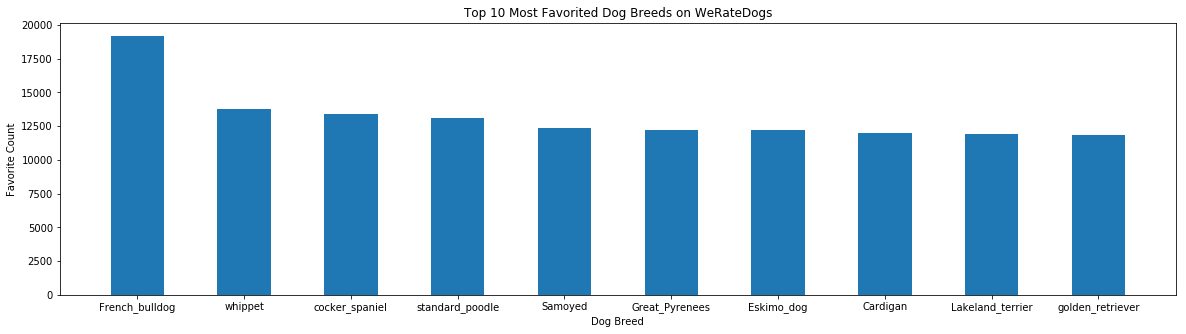

In [61]:
% matplotlib inline
# Plot a visualisation of the top 10 dog breeds

x = np.arange(10)
plt.figure(figsize=(20,5));
plt.bar(x, top10_df.values, width=0.5)
plt.xticks(x, top10_df.index);
plt.xlabel('Dog Breed');
plt.ylabel('Favorite Count');
plt.title('Top 10 Most Favorited Dog Breeds on WeRateDogs');